# Lab Assignment Two: Exploring Image Data 

## Team Members

| Member | Name               |
|--------|--------------------|
| 1      | Pham, Tuan Thanh   |
| 2      | Lomelin, Nicko     |
| 3      | Butcher, Karrie Zenobia |


## I. Library & Data Import

In [ ]:
# === Library Import & File Path ===
import zipfile, io, random  # Library functions: for file handling, randomization
from pathlib import Path  # Library functions: for file path
from PIL import Image  # Library functions: for image processing
import numpy as np  # Library functions: for numerical operations
import pandas as pd  # Library functions: for data manipulation
import matplotlib.pyplot as plt  # Library functions: for plotting
# import seaborn as sns  # Optional: for heatmap visualization

from sklearn.decomposition import PCA  # Library functions: for PCA
from sklearn.neighbors import KNeighborsClassifier  # Classifier
from sklearn.model_selection import train_test_split  # Train/test split
from sklearn.metrics import classification_report, confusion_matrix  # Evaluation

from skimage.feature import daisy  # DAISY feature extraction
from skimage.color import rgb2gray  # Grayscale conversion


In [ ]:
# === Path to ZIP in Downloads ===
base_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd().parent
zip_path = base_dir / "data" / "archive.zip"

## II. Business Understanding (Karrie)

In [11]:
### Insert Business Understanding Here

## III. Data Preparation

Feature matrix shape: (5631, 12288)


,filename,0,1,2,3,4,5,6,7,8,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,data/green_area/Forest_2861.jpg,0.094118,0.192157,0.278431,0.105882,0.184314,0.282353,0.105882,0.172549,0.274510,...,0.290196,0.133333,0.215686,0.290196,0.160784,0.219608,0.294118,0.196078,0.227451,0.309804
1,data/green_area/Forest_1972.jpg,0.152941,0.266667,0.290196,0.152941,0.266667,0.282353,0.164706,0.278431,0.294118,...,0.262745,0.145098,0.258824,0.282353,0.137255,0.250980,0.274510,0.137255,0.250980,0.266667
2,data/green_area/Forest_202.jpg,0.168627,0.274510,0.317647,0.168627,0.274510,0.317647,0.172549,0.282353,0.325490,...,0.321569,0.207843,0.294118,0.337255,0.184314,0.270588,0.313726,0.184314,0.270588,0.313726
3,data/water/SeaLake_1531.jpg,0.321569,0.415686,0.462745,0.321569,0.415686,0.454902,0.325490,0.419608,0.458824,...,0.439216,0.298039,0.419608,0.439216,0.305882,0.419608,0.450980,0.317647,0.411765,0.450980
4,data/water/SeaLake_2891.jpg,0.270588,0.325490,0.368627,0.258824,0.321569,0.372549,0.258824,0.329412,0.376471,...,0.349020,0.274510,0.466667,0.341176,0.274510,0.466667,0.352941,0.274510,0.462745,0.360784


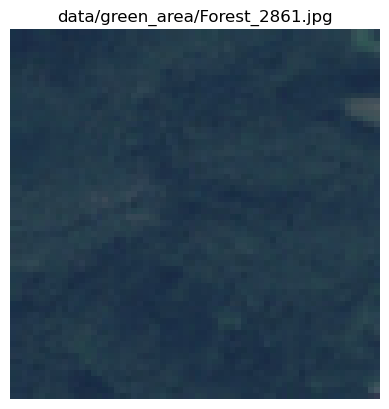

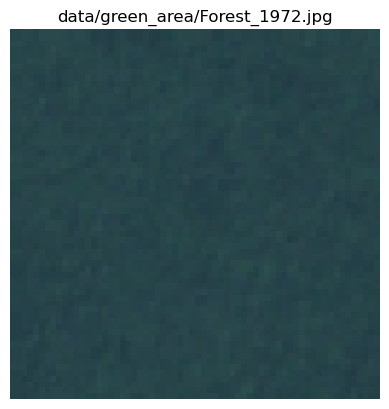

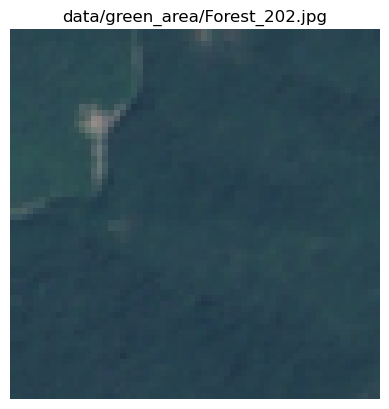

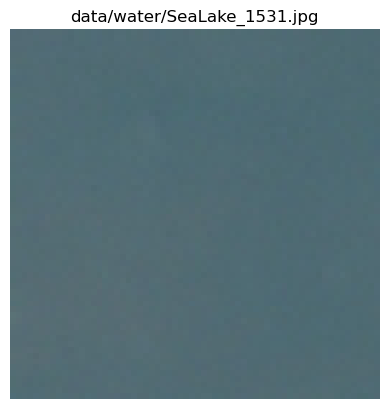

In [33]:
# === Settings ===
target_size = (64, 64)           # resize width × height

# === Read images (randomized order) ===
features, filenames = [], []

with zipfile.ZipFile(zip_path, 'r') as zf:
    # collect all image names
    names = [n for n in zf.namelist() 
             if n.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".webp"))]
    
    # shuffle order
    random.shuffle(names)
    
    for name in names:
        try:
            with zf.open(name) as file:
                img = Image.open(io.BytesIO(file.read())).convert("RGB")
                img = img.resize(target_size)
                
                # normalize [0,1] and flatten to 1-D
                arr_flat = (np.array(img, dtype=np.float32) / 255.0).flatten()
                features.append(arr_flat)
                filenames.append(name)
        except Exception as e:
            print(f"Skipping {name}: {e}")

features = np.array(features)   # shape = (n_images, 12288)
print("Feature matrix shape:", features.shape)

# === Put into a DataFrame ===
df = pd.DataFrame(features)
df.insert(0, "filename", filenames)
display(df.head())

# === Visualize a few images (randomized) ===
for i in range(min(4, len(features))):
    plt.imshow(features[i].reshape(64, 64, 3))
    plt.title(filenames[i])
    plt.axis("off")
    plt.show()


## IV. Data Reduction

In [34]:
# Set Up data for PCA
X = features.copy()
h, w = target_size

### - PCA & Randomized PCA

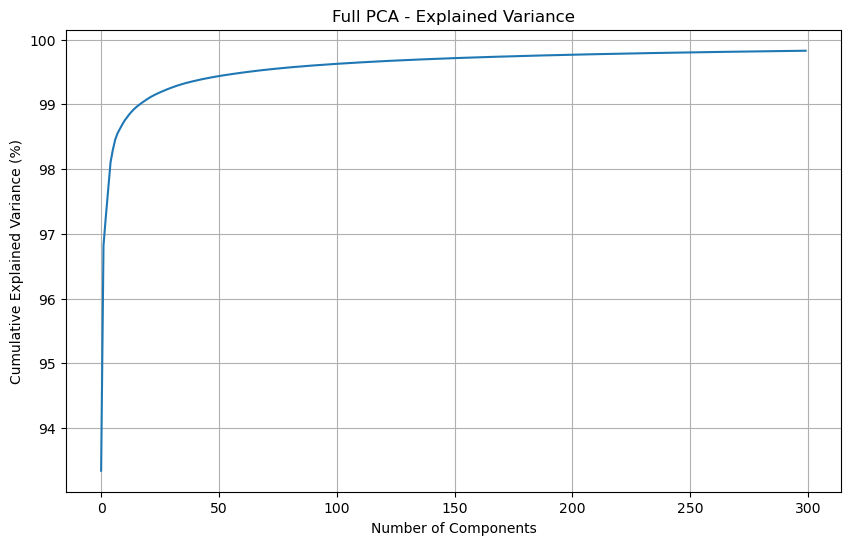

Full PCA: To capture 90% variance = 1 comps
Full PCA: To capture 95% variance = 2 comps


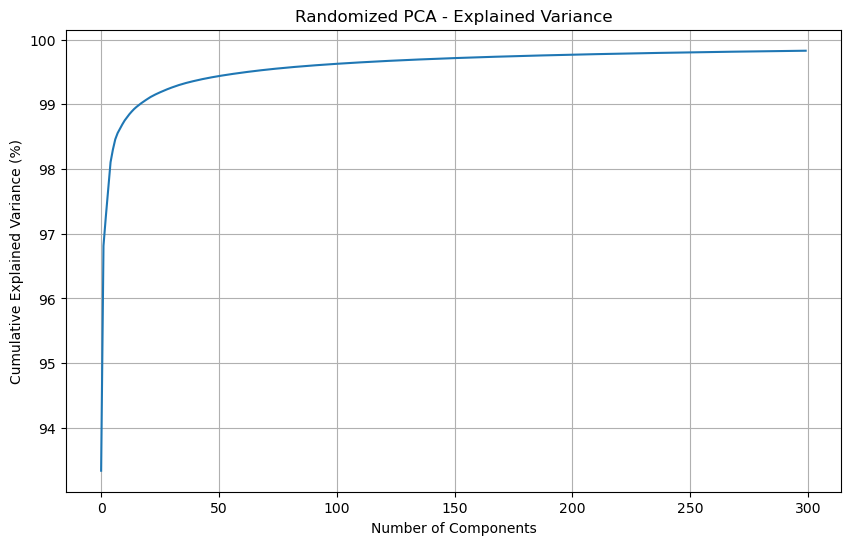

Randomized PCA: To capture 90% variance = 1 comps
Randomized PCA: To capture 95% variance = 2 comps


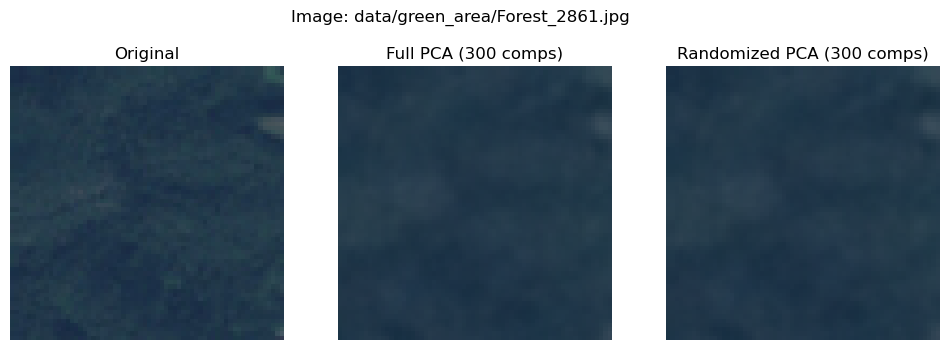

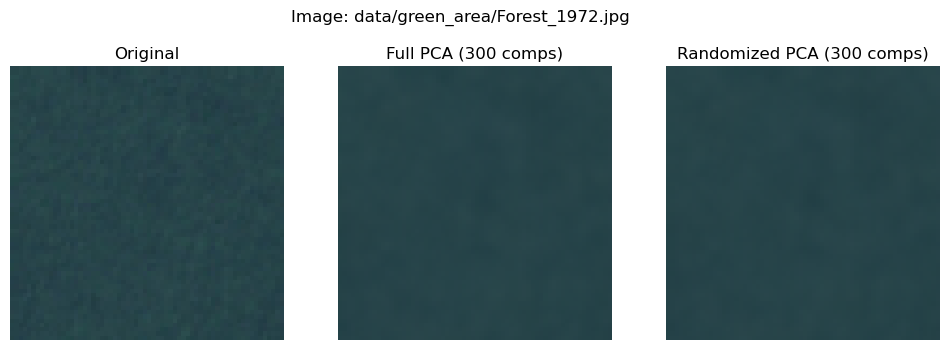

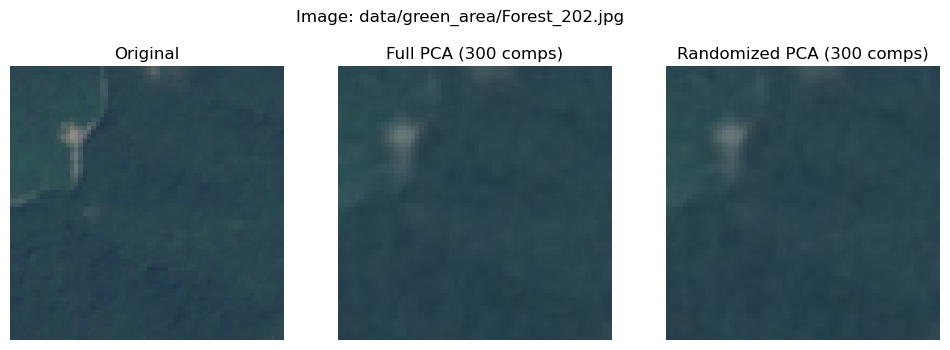

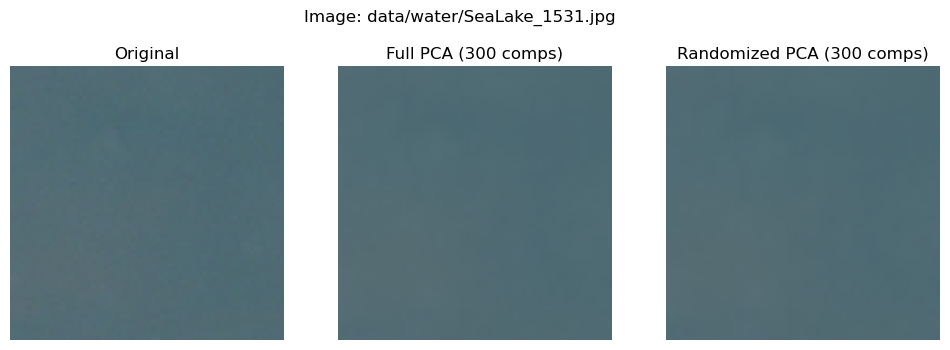

In [35]:
# === Full PCA ===
n_components = 300   # you can adjust this
pca = PCA(n_components=n_components, svd_solver="full", random_state=42)
pca.fit(X)

# Explained variance plot
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Full PCA - Explained Variance")
plt.grid(True)
plt.show()

# How many components needed?
explained = np.cumsum(pca.explained_variance_ratio_)
dims_90 = np.argmax(explained >= 0.90) + 1
dims_95 = np.argmax(explained >= 0.95) + 1
print(f"Full PCA: To capture 90% variance = {dims_90} comps")
print(f"Full PCA: To capture 95% variance = {dims_95} comps")


# === Randomized PCA ===
rpca = PCA(n_components=n_components, svd_solver="randomized", random_state=42)
rpca.fit(X)

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(rpca.explained_variance_ratio_)*100)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Randomized PCA - Explained Variance")
plt.grid(True)
plt.show()

explained_rpca = np.cumsum(rpca.explained_variance_ratio_)
dims_90_rpca = np.argmax(explained_rpca >= 0.90) + 1
dims_95_rpca = np.argmax(explained_rpca >= 0.95) + 1
print(f"Randomized PCA: To capture 90% variance = {dims_90_rpca} comps")
print(f"Randomized PCA: To capture 95% variance = {dims_95_rpca} comps")


# === Image reconstruction comparison for first 4 images ===
def reconstruct_and_show(idx, transformer):
    x_flat = X[idx].reshape(1, -1)
    low_rep = transformer.transform(x_flat)
    rec = transformer.inverse_transform(low_rep)
    return rec.reshape(h, w, 3)

num_show = min(4, len(features))
for idx in range(num_show):
    plt.figure(figsize=(12,4))

    # Original
    plt.subplot(1,3,1)
    plt.imshow(X[idx].reshape(h,w,3))
    plt.title("Original")
    plt.axis("off")

    # Full PCA reconstruction
    plt.subplot(1,3,2)
    plt.imshow(reconstruct_and_show(idx, pca))
    plt.title(f"Full PCA ({n_components} comps)")
    plt.axis("off")

    # Randomized PCA reconstruction
    plt.subplot(1,3,3)
    plt.imshow(reconstruct_and_show(idx, rpca))
    plt.title(f"Randomized PCA ({n_components} comps)")
    plt.axis("off")

    plt.suptitle(f"Image: {filenames[idx]}")
    plt.show()



### Analysis of PCA and Randomized PCA Dimensionality Review:

Both standard Principal Components Analysis (PCA) and Randomized PCA were applied to the image dataset to examine how many dimensions are required to adequately represent the data. The explained variance plots for both methods show a very steep rise within the first few components, indicating that most of the information is captured in the leading dimensions.

For regular PCA, results show that:

1 component is sufficient to explain approximately 90% of the variance.

2 components are enough to explain about 95% of the variance.

For Randomized PCA, the results are nearly identical. The stochastic approximation introduces only minor differences, but the same thresholds are reached at the same component counts:

1 component for 90% variance.

2 components for 95% variance.

This suggests that the dataset is highly redundant in its original pixel representation, with the majority of variance explained by just a few dominant features (e.g., global intensity or color patterns). Adding more than ~10–20 components yields diminishing returns, as the cumulative variance curve quickly levels off.

Conclusion:
Both PCA and Randomized PCA demonstrate that only 2 principal components are required to preserve at least 95% of the variance in the dataset. Randomized PCA is preferable for very large datasets due to its faster computation, while full PCA provides exact results. In either case, the dimensionality of the dataset can be drastically reduced with minimal information loss.

### - Feature Extration (Daisy)

Image 0: DAISY descriptors shape = (5, 5, 200)


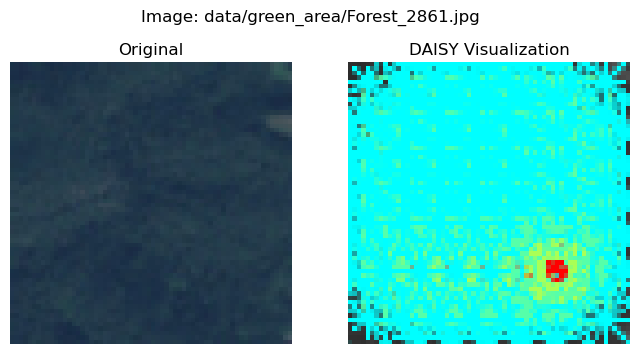

Image 1: DAISY descriptors shape = (5, 5, 200)


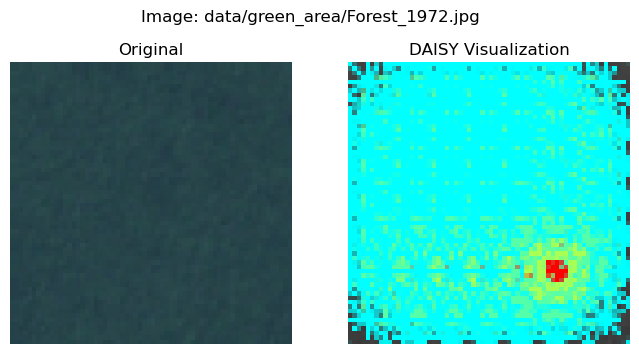

Image 2: DAISY descriptors shape = (5, 5, 200)


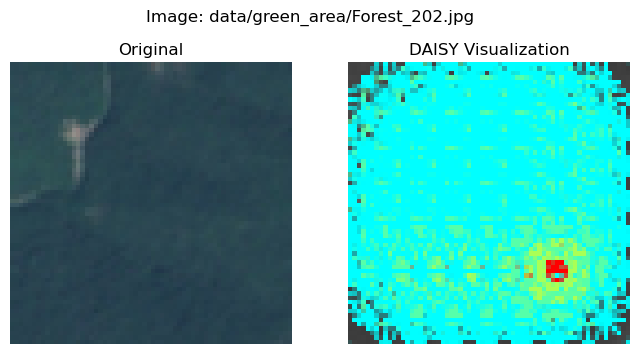

Image 3: DAISY descriptors shape = (5, 5, 200)


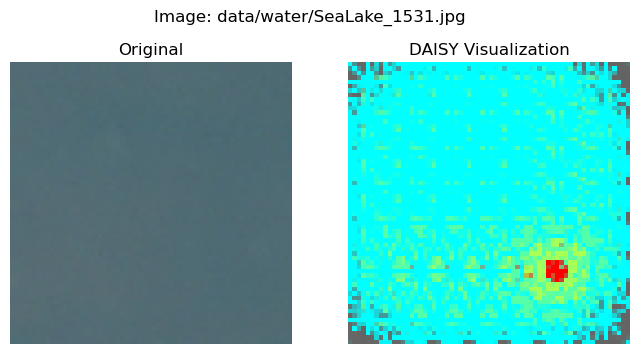

In [37]:
# choose a few images to demo
num_show = min(4, len(features))

#set up for loop for feature extraction
for idx in range(num_show):
    img = X[idx].reshape(h, w, 3) #reshape image to 64x64x3 (we have rgb image with 64x64 pixels then have 3 colors) 
    gray = rgb2gray(img) #convert to grayscale

    # DAISY feature extraction
    descs, descs_img = daisy(
        gray,
        step=8,              # distance between keypoints
        radius=15,           # radius of the region around keypoints
        rings=3,             # number of rings
        histograms=8,        # number of histograms
        orientations=8,      # number of gradient orientations
        visualize=True
    )

    # descs shape = (number of keypoints vertically, number of keypoints horizontally, feature length)
    print(f"Image {idx}: DAISY descriptors shape = {descs.shape}")

    # display original image and DAISY visualization
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(descs_img, cmap='gray')
    plt.title("DAISY Visualization")
    plt.axis("off")

    plt.suptitle(f"Image: {filenames[idx]}")
    plt.show()


### - Evaluation of DAISY Features for Prediction Task


Feature matrix shape: (5631, 5000)
Labels shape: (5631,)

Classification Report:
               precision    recall  f1-score   support

      cloudy       0.87      0.56      0.68       450
      desert       0.33      0.12      0.17       340
  green_area       0.41      0.22      0.29       450
       water       0.39      0.89      0.54       450

    accuracy                           0.47      1690
   macro avg       0.50      0.45      0.42      1690
weighted avg       0.51      0.47      0.44      1690


Confusion Matrix:
 [[253   7  23 167]
 [ 15  40 103 182]
 [  4  64 101 281]
 [ 20  10  20 400]]


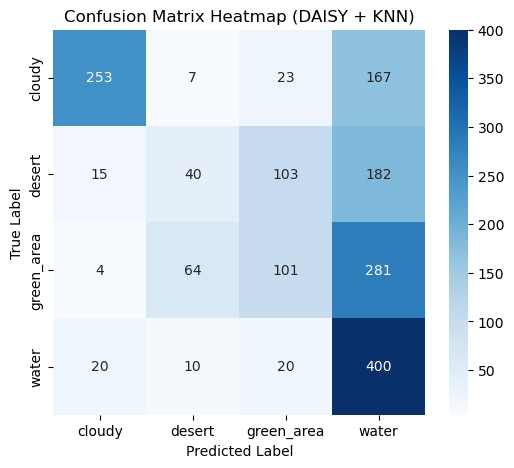

In [45]:
import seaborn as sns #optional library for heatmap

X_daisy, y_labels = [], [] #set up empty list for features (DAISY descriptors flatten) và labels (cloudy/desert/…).

# === Extract DAISY features for all dataset ===
for idx in range(len(features)):
    img = X[idx].reshape(h, w, 3)
    gray = rgb2gray(img)

    # only extract descriptor, not visualize to run faster
    descs = daisy(
        gray,
        step=8,
        radius=15,
        rings=3,
        histograms=8,
        orientations=8,
        visualize=False
    )

    # Flatten descriptor to vector
    X_daisy.append(descs.flatten())

    # Create label from filename
    if "cloudy" in filenames[idx].lower():
        y_labels.append("cloudy")
    elif "desert" in filenames[idx].lower():
        y_labels.append("desert")
    elif "green_area" in filenames[idx].lower():
        y_labels.append("green_area")
    elif "water" in filenames[idx].lower():
        y_labels.append("water")
    else:
        y_labels.append("other")

X_daisy = np.array(X_daisy)
y_labels = np.array(y_labels)

print("Feature matrix shape:", X_daisy.shape)
print("Labels shape:", y_labels.shape)

# === Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_daisy, y_labels, test_size=0.3, random_state=42, stratify=y_labels #train/test split with 70/30 method
)

# === KNN Classifier ===
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# === Evaluation ===
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# === Confusion Matrix Heatmap ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_labels),
            yticklabels=np.unique(y_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap (DAISY + KNN)")
plt.show()


### - Conclusion  

- Based on the classification report and the 70/30 train-test split (chosen to balance learning capacity and unbiased evaluation):  
  - **Accuracy = 0.47** → relatively low, close to random guessing for 4 classes.  
  - **Precision/Recall insights**:  
    - **Cloudy**: High precision (0.87) but lower recall (0.56). The model is usually correct when it predicts “cloudy,” but it still misses many cloudy images.  
    - **Water**: Very high recall (0.89) but lower precision. Most water images are detected, but the model often misclassifies other classes as water.  
    - **Desert & Green Area**: Both show weak performance, meaning DAISY features are not strong enough to clearly separate these categories.  

**Final conclusion**: DAISY does capture some useful patterns (e.g., it works relatively well for clouds and water), but it struggles to distinguish more subtle differences like desert vs. green area. This suggests that while DAISY has potential, better results would likely require tuning its parameters (*step, radius, rings, histograms*) or combining it with other techniques such as **PCA** for noise reduction, **HOG**, or more advanced approaches like **CNNs**.  

Optional:
The confusion matrix heatmap confirms the report results:  
- "Cloudy" and "Water" dominate their correct columns, showing the model recognizes these better.  
- "Desert" and "Green Area" are heavily mixed, with many samples misclassified into other classes.  



## V. Exceptional Work

In [ ]:
### - Exceptional Work Code